# INIT

In [72]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


In [73]:
raw_data = "./raw_data/"
raw_artists = pd.read_csv(f'{raw_data}raw_artists.csv', sep=';', index_col=0)
raw_tracks = pd.read_csv(f'{raw_data}raw_tracks.csv', sep=',', index_col=0)

In [74]:
data = "./data/"
artists = pd.read_csv(f'{data}artists.csv', sep=';', index_col=0)
tracks = pd.read_csv(f'{data}tracks.csv', sep=',', index_col=0)

# DATA UNDERSTANDING ARTISTS

## Check of data values validity and missing values

In [75]:
# General Information about the original dataset
summary = pd.DataFrame({
    'dtype': raw_artists.dtypes,
    'unique_values': raw_artists.nunique(),
    'missing_values': raw_artists.isna().sum(),
    'missing_percent': raw_artists.isna().mean() * 100
})
# Ordina il riepilogo per numero decrescente di valori mancanti
summary = summary.sort_values(by='missing_values', ascending=False)
print(summary)

print("We can see that active_end is missing in all rows, so we can drop this column.\nActive start can be imputed based on oldest track year per artist.\nRegion and province can be imputed using birth place but will add some noise.\nNationality can ne set to Italia for every one.\n longitude and latitude can be droipped as they don't provide meaningfull information.\nMissing birth places and dates must be found by external means.\ndescription can be useful for identifying groups.\n gender and name don't miss any values and don't present strange ones.\n")

                dtype  unique_values  missing_values  missing_percent
active_end    float64              0             104       100.000000
active_start   object             24              54        51.923077
region         object             13              36        34.615385
province       object             26              34        32.692308
country        object              1              34        32.692308
nationality    object              2              33        31.730769
latitude      float64             40              32        30.769231
longitude     float64             40              32        30.769231
birth_place    object             40              32        30.769231
birth_date     object             73              31        29.807692
description    object             69              18        17.307692
gender         object              2               0         0.000000
name           object            104               0         0.000000
We can see that acti

In [76]:
print("we fill missng nationalities with 'Italia' as basically all of them are italians")
print(artists["nationality"].unique())
print(artists["nationality"].describe())
artists["nationality"] = artists["nationality"].fillna("Italia")

artists.info()

we fill missng nationalities with 'Italia' as basically all of them are italians
[nan 'Italia' 'Argentina']
count         71
unique         2
top       Italia
freq          70
Name: nationality, dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, ART82291002 to ART83631935
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          104 non-null    object 
 1   gender        104 non-null    object 
 2   birth_date    73 non-null     object 
 3   birth_place   72 non-null     object 
 4   nationality   104 non-null    object 
 5   description   86 non-null     object 
 6   active_start  50 non-null     object 
 7   active_end    0 non-null      float64
 8   province      70 non-null     object 
 9   region        68 non-null     object 
 10  country       70 non-null     object 
 11  latitude      72 non-null     float64
 12  longitude     72 non-null     object 
dtypes: float64(2), object(1

In [77]:
print(artists["birth_date"].describe())
print("We check if birth dates are in a plausible range of values and types")
birth_years = pd.to_datetime(artists['birth_date'], errors='coerce').dt.year
print(birth_years.describe())

count             73
unique            73
top       1990-07-11
freq               1
Name: birth_date, dtype: object
We check if birth dates are in a plausible range of values and types
count      72.000000
mean     1986.875000
std         8.903137
min      1967.000000
25%      1979.750000
50%      1988.500000
75%      1993.250000
max      2002.000000
Name: birth_date, dtype: float64


In [78]:
print("since we lost 1 birth date converting to year only, we check that line")
print(artists["birth_date"].unique())
print("We see a wrong value and set it to NaN, then check again")

artists.loc[artists["birth_date"] == 'http://www.wikidata.org/.well-known/genid/4111f32c49a23235b2e902dc8621d27c', ["birth_date"]] = [np.nan]

print(artists["birth_date"].unique())
print("Now all values are either dates or NaN")


since we lost 1 birth date converting to year only, we check that line
[nan '1990-07-11' '1975-08-08' '1983-02-05' '1973-08-03' '1973-10-09'
 '1998-04-20' '1998-11-07' '1982-12-21' '1983-07-11' '1993-11-05'
 '1975-05-15' '1997-05-16' '1989-11-14' '1985-12-13' '1985-03-16'
 '1993-11-29' '1976-10-17' '1989-10-15' '1989-12-27' '1969-08-18'
 '1989-11-03' '1988-11-04' '2000-03-23' '1993-05-21' '1982-04-01'
 '1979-03-30' '1990-05-14' '1997-01-01' '1979-10-02' '1972-08-05'
 '1982-12-20' '1979-02-25' '1970-06-20' '1994-08-22' '1981-01-07'
 '2002-01-16' '1988-07-25' '1992-09-12' '1991-08-16' '1979-05-22'
 '1993-11-30' '1976-09-11' '1986-12-01' '1991-11-19' '1986-10-17'
 '1967-10-07' '1980-12-29' '1997-07-22' '1993-02-11' '1979-12-15'
 '2001-02-19' '1973-04-26' '1989-07-19' '1994-04-19' '1994-11-21'
 '2002-04-29' '1998-01-30' '1989-07-20' '1995-09-18' '1984-06-29'
 '1992-12-07' '1980-11-17' '1987-12-10'
 'http://www.wikidata.org/.well-known/genid/4111f32c49a23235b2e902dc8621d27c'
 '1987-01-24' '

In [79]:
# print("We correct the birth date and place of shiva")
# print(artists["birth_date"])

# print(f"artists birth date info: {artists["birth_date"].describe()}\n {artists["birth_date"].dropna().unique()}")

# artists.loc[artists["name"] == "shiva", ["birth_date","birth_place"]] = [["1999-08-27","Genova"]]
# print(artists.loc[artists["name"] == "shiva",["name","birth_date","birth_place"]])

In [80]:
print("We do the same check for active_start")
print(artists["active_start"].describe())
active_start_years = pd.to_datetime(artists['active_start'], errors='coerce').dt.year
print(active_start_years.describe())

print("No values lost converting to year only so all values are either dates or NaN, we proceed to check for invalid data")

artists["birth_date"] = pd.to_datetime(artists["birth_date"], errors="coerce")
artists["active_start"] = pd.to_datetime(artists["active_start"], errors="coerce")

# Filter rows where active_start < birth_date
invalid_rows = artists[artists["active_start"] < artists["birth_date"]]

print(invalid_rows[["birth_date", "active_start"]])

print("There are no invalid rows where active_start is before birth_date")

We do the same check for active_start
count             50
unique            24
top       1996-01-01
freq               6
Name: active_start, dtype: object
count      50.000000
mean     2003.320000
std         8.546249
min      1988.000000
25%      1996.000000
50%      2004.000000
75%      2011.000000
max      2018.000000
Name: active_start, dtype: float64
No values lost converting to year only so all values are either dates or NaN, we proceed to check for invalid data
Empty DataFrame
Columns: [birth_date, active_start]
Index: []
There are no invalid rows where active_start is before birth_date


In [81]:
print("We drop usless columns: active_end, longitude, latitude")
artists = artists.drop(columns=['active_end', 'longitude', 'latitude'])

We drop usless columns: active_end, longitude, latitude


In [82]:
print("we check birth places, regions, provinces and countrys unique values to see if they make sense")
print(artists["birth_place"].unique())
print(artists["province"].unique())
print(artists["region"].unique())
print(artists["country"].unique())
print("\nAll values seems plausible")

we check birth places, regions, provinces and countrys unique values to see if they make sense
[nan 'Verona' 'Rho' 'Singapore' 'Milano' 'Sternatia' 'Salerno' 'Almería'
 'Avellino' 'Nocera Inferiore' 'La Spezia' 'Bologna' 'Vimercate'
 'Alpignano' 'Senigallia' 'Brescia' 'Torino' 'Roma' 'Napoli' 'Olbia'
 'Firenze' 'Scampia' 'Vicenza' 'Grottaglie' 'Nicosia' 'Gallarate'
 'Treviso' 'Desenzano del Garda' 'San Benedetto del Tronto' 'Scafati'
 'Pieve Emanuele' 'San Siro' 'Grugliasco' 'Lodi' 'Sesto San Giovanni'
 'Buenos Aires' 'Genova' 'Fiumicino' 'Padova' 'Reggio Calabria' 'Cagliari']
[nan 'Verona' 'Milano' 'Lecce' 'Salerno' 'Genova' 'Avellino' 'La Spezia'
 'Bologna' 'Monza e della Brianza' 'Torino' 'Ancona' 'Brescia' 'Roma'
 'Napoli' 'Gallura' 'Firenze' 'Vicenza' 'Taranto' 'Enna' 'Varese'
 'Treviso' 'Ascoli Piceno' 'Lodi' 'Padova' 'Reggio Calabria' 'Cagliari']
[nan 'Veneto' 'Lombardia' 'Puglia' 'Campania' 'Liguria' 'Emilia-Romagna'
 'Piemonte' 'Lazio' 'Sardegna' 'Toscana' 'Sicilia' 'Marche' '

### Inference of artists data when possible

In [83]:
print("Identify rows with many missing values")
missing_pct = artists.isna().mean(axis=1)

threshold = 0.4
rows_with_many_missing = artists[missing_pct > threshold]
# print(rows_with_many_missing)
print(rows_with_many_missing.info())
print(f"We miss data on {len(rows_with_many_missing)} over {len(artists)} artists ({(len(rows_with_many_missing)/len(artists))*100:.2f}%)")

Identify rows with many missing values
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, ART82291002 to ART71515715
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   name          32 non-null     object        
 1   gender        32 non-null     object        
 2   birth_date    0 non-null      datetime64[ns]
 3   birth_place   0 non-null      object        
 4   nationality   32 non-null     object        
 5   description   14 non-null     object        
 6   active_start  6 non-null      datetime64[ns]
 7   province      0 non-null      object        
 8   region        0 non-null      object        
 9   country       0 non-null      object        
dtypes: datetime64[ns](2), object(8)
memory usage: 2.8+ KB
None
We miss data on 32 over 104 artists (30.77%)


In [84]:
#CHECK OF HOW MUCH DATA WE LOSE IF WE DROP THESE ROWS

# print(tracks.columns)
# print(rows_with_many_missing.columns)
# print(artists.columns)


merged = tracks.merge(
    artists,
    left_on="id_artist",
    right_on="id_author",  
    how="left"
)

merged = merged[merged["id_artist"].isin(rows_with_many_missing.index)]
# print(merged[["id_artist", "name", "title", "birth_place", "birth_date", "year"]])
temp = merged[["id_artist", "name", "title", "birth_place", "birth_date", "year", "active_start"]]
# temp.to_csv("./data/temp/tracks_artists_with_many_missing.csv", sep=';', index=False)
# print(merged.describe())
print(merged.info())
print(f"If we drop artists with many missing values we loose {len(merged)} over {len(tracks)} tracks ({(len(merged)/len(tracks))*100:.2f}%)")
# print(merged)

<class 'pandas.core.frame.DataFrame'>
Index: 2578 entries, 70 to 10343
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_artist             2578 non-null   object        
 1   name_artist           2578 non-null   object        
 2   full_title            2578 non-null   object        
 3   title                 2578 non-null   object        
 4   featured_artists      758 non-null    object        
 5   primary_artist        2578 non-null   object        
 6   language              2556 non-null   object        
 7   album                 2220 non-null   object        
 8   stats_pageviews       835 non-null    float64       
 9   swear_IT              2578 non-null   int64         
 10  swear_EN              2578 non-null   int64         
 11  swear_IT_words        2578 non-null   object        
 12  swear_EN_words        2578 non-null   object        
 13  year                 

In [85]:
# rows_with_many_missing.to_csv("./data/temp/artists_with_many_missing.csv", sep=';', index=False)


In [86]:
# IMPORT MISSING VALUES FROM OUTSIDE SOURCE
gpt = pd.read_csv("./data/temp/gpt_missing_artists.csv", sep=';', index_col=0)

In [87]:
# CHECK HOW MANY ARE STILL MISSING

gpt = gpt[gpt["birth_date"].isna()]
# print(gpt)

merged_gpt = tracks.merge(
    artists,
    left_on="id_artist",
    right_on="id_author",
    how="left"
)

matching_ids = artists.loc[artists["name"].isin(gpt.index)].index
# print(matching_ids)
merged_gpt = merged_gpt[merged_gpt["id_artist"].isin(matching_ids)]
print(merged_gpt.info())
print(f"If we drop artists still missing birth date after gpt imputation we lose {len(merged_gpt)} over {len(tracks)} tracks ({(len(merged_gpt)/len(tracks))*100:.2f}%)")
# print(merged_gpt[["id_artist", "name", "title", "birth_place", "birth_date", "year"]])

# merged_gpt.to_csv("./data/temp/tracks_artists_gpt_missing.csv", sep=';', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1121 entries, 1806 to 9828
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_artist             1121 non-null   object        
 1   name_artist           1121 non-null   object        
 2   full_title            1121 non-null   object        
 3   title                 1121 non-null   object        
 4   featured_artists      312 non-null    object        
 5   primary_artist        1121 non-null   object        
 6   language              1108 non-null   object        
 7   album                 1030 non-null   object        
 8   stats_pageviews       318 non-null    float64       
 9   swear_IT              1121 non-null   int64         
 10  swear_EN              1121 non-null   int64         
 11  swear_IT_words        1121 non-null   object        
 12  swear_EN_words        1121 non-null   object        
 13  year                

In [ ]:
print("We can keep rows in artists where description identify it as a group and impute missing values based on tracks release years")

group_ids = artists[artists["description"].str.contains("gruppo musicale", case=False, na=False)].index
# print(group_ids)
matching_ids = matching_ids[~matching_ids.isin(group_ids)]
# print(matching_ids)

merged_gpt = merged_gpt[merged_gpt["id_artist"].isin(matching_ids)]
print(merged_gpt.info())
print(f"If we drop artists still missing birth date after gpt imputation we lose {len(merged_gpt)} over {len(tracks)} tracks ({(len(merged_gpt)/len(tracks))*100:.2f}%)")


We can keep rows in artists where description identify it as a group and impute missing values based on tracks release years
<class 'pandas.core.frame.DataFrame'>
Index: 310 entries, 1983 to 9796
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_artist             310 non-null    object        
 1   name_artist           310 non-null    object        
 2   full_title            310 non-null    object        
 3   title                 310 non-null    object        
 4   featured_artists      83 non-null     object        
 5   primary_artist        310 non-null    object        
 6   language              305 non-null    object        
 7   album                 256 non-null    object        
 8   stats_pageviews       36 non-null     float64       
 9   swear_IT              310 non-null    int64         
 10  swear_EN              310 non-null    int64         
 11  swear_IT_wor

## ARTISTS STATS AND DISTR

In [89]:
print(artists['birth_place'].describe())

count         72
unique        40
top       Milano
freq          15
Name: birth_place, dtype: object


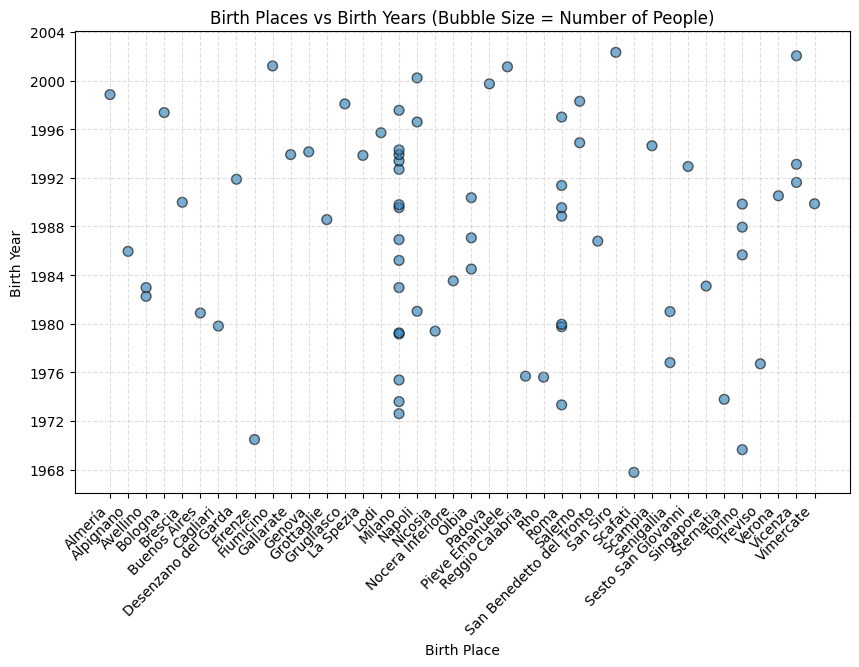

In [90]:
counts = (
    artists.groupby(['birth_place', 'birth_date'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(10,6))
plt.scatter(
    counts['birth_place'], 
    counts['birth_date'], 
    s=(counts['count'] ** 2) * 50,  # scale up sizes for visibility
    alpha=0.6, 
    edgecolor='k'
)

plt.xlabel('Birth Place')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Birth Year')
plt.title('Birth Places vs Birth Years (Bubble Size = Number of People)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


# STUDY OF THE LYRICS

In [91]:
# Statistiche descrittive delle metriche linguistiche calcolate

print("STATISTICHE DESCRITTIVE DELLE METRICHE LYRICS")

print("\n1. N_SENTENCES - Numero di frasi nelle lyrics")
print(tracks.n_sentences.describe())

print("\n2. N_TOKENS - Numero di parole (token) nelle lyrics")
print(tracks.n_tokens.describe())
print(tracks['n_tokens'].quantile([0.01, 0.02, 0.03, 0.04, 0.05]))

print("\n3. TOKENS_PER_SENT - Media di parole per frase")
print(tracks.tokens_per_sent.describe())

print("\n4. CHAR_PER_TOK - Media di caratteri per parola (lunghezza media parola)")
print(tracks.char_per_tok.describe())

print("\n5. LEXICAL_DENSITY - Densità lessicale (parole uniche / parole totali)")
print(tracks.lexical_density.describe())

print("\n6. AVG_TOKEN_PER_CLAUSE - Media di parole per clausola (proposizione)")
print(tracks.avg_token_per_clause.describe())



STATISTICHE DESCRITTIVE DELLE METRICHE LYRICS

1. N_SENTENCES - Numero di frasi nelle lyrics
count    11090.000000
mean        59.399639
std         24.711996
min          1.000000
25%         46.000000
50%         58.000000
75%         73.000000
max        437.000000
Name: n_sentences, dtype: float64

2. N_TOKENS - Numero di parole (token) nelle lyrics
count    11090.000000
mean       496.891253
std        209.187612
min          3.000000
25%        372.000000
50%        491.000000
75%        615.000000
max       3089.000000
Name: n_tokens, dtype: float64
0.01     10.00
0.02     65.78
0.03    118.67
0.04    147.00
0.05    167.00
Name: n_tokens, dtype: float64

3. TOKENS_PER_SENT - Media di parole per frase
count    11090.000000
mean         8.672152
std          5.675602
min          1.500000
25%          7.333333
50%          8.404762
75%          9.431527
max        400.000000
Name: tokens_per_sent, dtype: float64

4. CHAR_PER_TOK - Media di caratteri per parola (lunghezza media par

In [92]:
# raw_tracks.to_csv("./data/temp/prova.csv", sep=';')